In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

# Monte Carlo Methods

### Desired Distribution
Let $P(x) = 3e^{-\frac{x^2}{2}} + e^{-\frac{(x-4)^2}{2}}$ be the distribution we want to sample from. Note that this is an unnormalized distribution with a normalizing constant $Z$ we can compute but let's keep it as it is.     
($Z \approx 10.0261955464$)  

**Note**: For all methods that follow, except Gibbs Sampling, we'll use the same $P(x)$.

In [2]:
P = lambda x: 3 * np.exp(-x*x/2) + np.exp(-(x - 4)**2/2)
Z = 10.0261955464

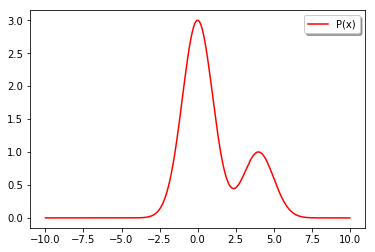

In [3]:
x_vals = np.linspace(-10, 10, 1000)
y_vals = P(x_vals)
plt.figure(1)
plt.plot(x_vals, y_vals, 'r', label='P(x)')
plt.legend(loc='upper right', shadow=True)
plt.show()

Let the functions that we want to approximate be $f(x) = x$ and $g(x) = \sin(x)$. The two values for a unnormalized $P$ are as follows:
* $\mathbb{E}[x] \approx 10.02686647165 $
* $\mathbb{E}[\sin(x)] \approx -1.15088010640 $

In [4]:
f_x = lambda x: x
g_x = lambda x: np.sin(x)
true_expected_fx = 10.02686647165
true_expected_gx = -1.15088010640

### Importance Sampling
$$\mathbb{E}_{x \sim P}[f(x)] = \mathbb{E}_{x \sim Q}\Big[f(x)\frac{P(x)}{Q(x)}\Big]$$
Which means  $\mathbb{E}_{x \sim P}[f(x)] \approx \frac{1}{n}\sum_{i=1}^nf(x_i)\frac{P(x_i)}{Q(x_i)}$ where $x_i$ are drawn from $Q$. This applies when $P$ and $Q$ are both normalized. For unnormalized case    
$$\mathbb{E}_{x \sim P}[f(x)] \approx \frac{\sum_{i=1}^nf(x_i)\frac{P(x_i)}{Q(x_i)}}{\sum_{i=1}^n\frac{P(x_i)}{Q(x_i)}}$$  
Let the proposal distribution $Q(x)$ be a uniform distribution in $[-4,8]$.   
$Q(x) = \frac{1}{8 + 4}$ for $x \in [-4,8]$

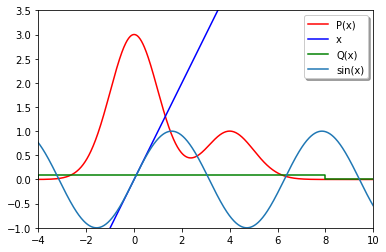

In [5]:
a, b = -4, 8
uniform_prob = 1./(b - a)
plt.figure(2)
plt.plot(x_vals, y_vals, 'r', label='P(x)')
plt.plot(x_vals, f_x(x_vals), 'b', label='x')
plt.plot([-10, a, a, b, b, 10], [0, 0, uniform_prob, uniform_prob, 0, 0], 'g', label='Q(x)')
plt.plot(x_vals, np.sin(x_vals), label='sin(x)')
plt.xlim(-4, 10)
plt.ylim(-1, 3.5)
plt.legend(loc='upper right', shadow=True)
plt.show()

In [6]:
expected_f_x = 0.
expected_g_x = 0.
n_samples = 100000
den = 0.
for i in range(n_samples):
    sample = np.random.uniform(a, b)
    importance = P(sample) / uniform_prob
    den += importance
    expected_f_x += importance * f_x(sample)
    expected_g_x += importance * g_x(sample)
expected_f_x /= den
expected_g_x /= den
expected_f_x *= Z
expected_g_x *= Z
print('E[f(x)] = %.5f, Error = %.5f' % (expected_f_x, abs(expected_f_x - true_expected_fx)))
print('E[g(x)] = %.5f, Error = %.5f' % (expected_g_x, abs(expected_g_x - true_expected_gx)))

E[f(x)] = 9.92828, Error = 0.09858
E[g(x)] = -1.12657, Error = 0.02431


### Rejection Sampling
For a $cQ(x) > P(x)\,\,\forall\,\,x \in \mathbb{R}$, the rejection sampling can be done as follows.
* Sample $x_i \sim Q(x)$
* Sample $k_i \sim\mathit{Uniform}[0, cQ(x_i)]$
* Accept $x_i$ if $k_i < P(x_i)$    
Note: An accepted $x_i$ is automatically sampled from a normalized $P(x)$.    
In the following code $Q = \mathcal{N}(1,4^2)$

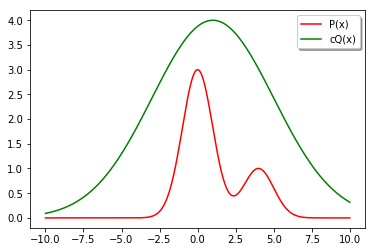

In [7]:
cQ = lambda x: 4 * np.exp(-(x-1)**2/(2.*16))
plt.figure(3)
plt.plot(x_vals, y_vals, 'r', label='P(x)')
plt.plot(x_vals, cQ(x_vals), 'g', label='cQ(x)')
plt.legend(loc='upper right', shadow=True)
plt.show()

In [8]:
expected_f_x = 0.
expected_g_x = 0.
n_samples = 100000
samples = []
for i in range(n_samples):
    sample = np.random.normal(1, 4)
    P_x = P(sample)
    bent_coin = np.random.uniform(0, cQ(sample))
    if bent_coin < P_x:
        samples.append(sample)
expected_f_x = np.mean(f_x(samples))
expected_g_x = np.mean(g_x(samples))
expected_f_x *= Z
expected_g_x *= Z
print('E[f(x)] = %.5f, Error = %.5f' % (expected_f_x, abs(expected_f_x - true_expected_fx)))
print('E[g(x)] = %.5f, Error = %.5f' % (expected_g_x, abs(expected_g_x - true_expected_gx)))

E[f(x)] = 10.21369, Error = 0.18682
E[g(x)] = -1.20520, Error = 0.05432


Compute the histogram of samples from Rejection Sampling and compare it with normalized $P(x)$. It's clear that rejection sampling generates samples from underlying normalized $P(x)$.

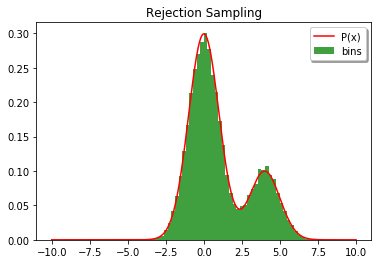

In [9]:
plt.hist(samples, bins=50, histtype='bar', facecolor='g', alpha=0.75, normed=1, label='bins')
plt.plot(x_vals, y_vals/Z, 'r', label='P(x)')
plt.title('Rejection Sampling')
plt.legend(loc='upper right', shadow=True)
plt.show()

## Markov Chain Monte Carlo

### Metropolis Hastings
For any $P(x)$, the Metropolis-Hastings algorithm proceeds as follows.
* Start at some $x_t = x_0$.
* Sample $x_i \sim Q(x|x_t)$
* $A = \min\Big(\frac{P(x_i)Q(x_t|x_i)}{P(x_t)Q(x_i|x_t)},1\Big)$
* Sample $k_i \sim Uniform[0,1]$
    * if $k_i < A$ then $x_{t+1} = x_i$
    * else $x_{t+1} = x_t$
    
As $t \rightarrow \infty$, $x_t$ comes from a normalized $P(x)$. The Markov chain takes some time to stabilize which is the burn-in phase. In the following code we ignore the first 1000 samples as burn-in.   
Here we choose $Q(x|x_t)$ as $\mathcal{N}(x_t, 1)$ which is actually equal to $Q(x_t|x)$ and should cancel but I have added it in the code for clarity.

In [10]:
Q = lambda t1, t0: np.exp(-(t1 - t0)**2/2)/(np.sqrt(2 * np.pi))
x0 = 0
xt = x0
samples = []
for i in range(100000):
    xt_candidate = np.random.normal(xt, 1)
    accept_prob = (P(xt_candidate) * Q(xt, xt_candidate))/(P(xt) * Q(xt_candidate, xt))
    if np.random.uniform(0, 1) < accept_prob:
        xt = xt_candidate
    samples.append(xt)
burn_in = 1000
samples = np.array(samples[burn_in:])
expected_f_x = np.mean(f_x(samples))
expected_g_x = np.mean(g_x(samples))
expected_f_x *= Z
expected_g_x *= Z
print('E[f(x)] = %.5f, Error = %.5f' % (expected_f_x, abs(expected_f_x - true_expected_fx)))
print('E[g(x)] = %.5f, Error = %.5f' % (expected_g_x, abs(expected_g_x - true_expected_gx)))

E[f(x)] = 9.29389, Error = 0.73297
E[g(x)] = -0.96110, Error = 0.18978


Compute the histogram of samples from Metropolis Hastings and compare it with normalized $P(x)$. It's clear that Metropolis Hastings algorithm generates samples from underlying normalized $P(x)$.

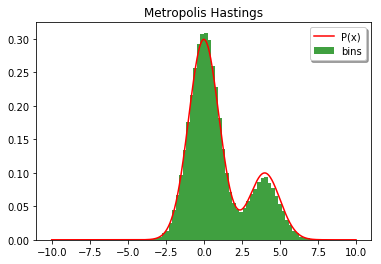

In [11]:
plt.hist(samples, bins=50, histtype='bar', facecolor='g', alpha=0.75, normed=1, label='bins')
plt.plot(x_vals, y_vals/Z, 'r', label='P(x)')
plt.title('Metropolis Hastings')
plt.legend(loc='upper right', shadow=True)
plt.show()

### Gibbs Sampling
For a multivariate distribution, $P(X)$, $X =  \begin{bmatrix}x_1 \\x_2 \end{bmatrix}$, Gibbs Sampling is performed as follows. It is assumed that it's difficult to sample from the joint distribution $P(x_1,x_2)$ but it's possible to sample from the conditional distributions $P(x_1|x_2)$ and $P(x_2|x_1)$.
* Start at some $X^t = \begin{bmatrix}x_1^0 \\x_2^0 \end{bmatrix}$
* Sample $x^{t+1}_1 \sim P(x_1|x_2^t)$
* Sample $x^{t+1}_2 \sim P(x_2|x^{t+1}_1)$
* $X^{t+1} = \begin{bmatrix}x^{t+1}_1 \\x^{t+1}_2 \end{bmatrix}$

Remove the first few samples as burn-in values.

Let $$P(X) = P(x_1,x_2) = \frac{1}{\sqrt{|2\pi\Sigma|}}e^{-\frac{1}{2}(X-\mu)^T\Sigma^{-1}(X-\mu)}$$
Where $\mu = \begin{bmatrix}0 \\0 \end{bmatrix}$ and $\Sigma = \begin{bmatrix}1 & b \\b & 1 \end{bmatrix}$ and $X =  \begin{bmatrix}x_1 \\x_2 \end{bmatrix}$ and $b = 0.8$    
The conditional probabilities are then given by
$$P(x_1|x_2) = \mathcal{N}(bx_2, 1-b^2)$$
$$P(x_2|x_1) = \mathcal{N}(bx_1, 1-b^2)$$

In [12]:
import numpy.linalg as LA
def multivariate_normal(X, mu=np.array([[0, 0]]), sig=np.array([[1, 0.8], [0.8, 1]])):
    sqrt_det_2pi_sig = np.sqrt(2 * np.pi * LA.det(sig))
    sig_inv = LA.inv(sig)
    X = X[:, None, :] - mu[None, :, :]
    return np.exp(-np.matmul(np.matmul(X, np.expand_dims(sig_inv, 0)), (X.transpose(0, 2, 1)))/2)/sqrt_det_2pi_sig

In [13]:
x = np.linspace(-3, 3, 1000)
X = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
X = np.reshape(X, [X.shape[0] * X.shape[1], -1])
z = multivariate_normal(X)

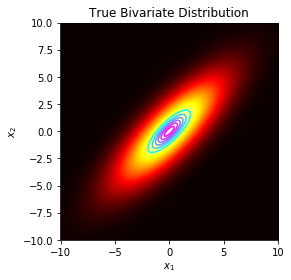

In [14]:
plt.imshow(z.squeeze().reshape([x.shape[0], -1]), extent=[-10, 10, -10, 10], cmap='hot', origin='lower')
plt.contour(x, x, z.squeeze().reshape([x.shape[0], -1]), cmap='cool')
plt.title('True Bivariate Distribution')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

In [15]:
x0 = [0, 0]
xt = x0
b = 0.8
samples = []
for i in range(100000):
    x1_t = np.random.normal(b*xt[1], 1-b*b)
    x2_t = np.random.normal(b*x1_t, 1-b*b)
    xt = [x1_t, x2_t]
    samples.append(xt)
burn_in = 1000
samples = np.array(samples[burn_in:])

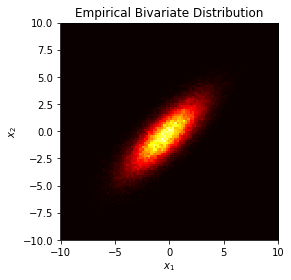

In [16]:
im, x_, y_ = np.histogram2d(samples[:, 0], samples[:, 1], bins=100, normed=True)
plt.imshow(im, extent=[-10, 10, -10, 10], cmap='hot', origin='lower', interpolation='nearest')
plt.title('Empirical Bivariate Distribution')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()